### Queen's University FEAS Uncertainty Calculator

In [2]:
"""
This cell contains all the code for the calculations. 
You can keep this cell collapsed by clicking on the blue line to the left unless you are interested in seeing how it works.
"""

# Import libraries
import matplotlib.pyplot as plt
from datetime import datetime
import math
# Try to set matplot lib to open graph in a new window, but if the qt backend is not available, plot in the notebook
try:
    %matplotlib qt
except ImportError:
    %matplotlib inline

# Global variables
formulaString = None
variableNames = None
targetVariable = None

# This *could* be expanded to enclude more functions that are included in the math module (list here: https://www.w3schools.com/python/module_math.asp) 
# however certain functions with overlapping names (i.e., 'cos' and 'acos') or names with numbers in them may cause problems. See processMathFunc function.
supportedMathFunc = ['sin', 'cos', 'tan', 'acos', 'asin', 'atan', 'sqrt', 'ln', 'log', 'pi', 'e']

# Returns current time in the format: %H:%M:%S.%f (hour, min, second, microsecond)
def getTime():
    return datetime.now().strftime("(%H:%M:%S.%f)")

# Conditional print function. Prints only if verbose = True
def vPrint(*args):
    string = ""
    if not verbose:
        return
    if args[0] == '\n':
        for x in args[1:]:
            string += str(x)
        print('\n', getTime(), string)
    else:
        for x in args:
            string += str(x)
        print(getTime(), string)
    return

# Take input from the user and process the function, identifing variables and saving result to the 3 global variables
def getFunctionFromUser():
    global formulaString
    global variableNames
    global targetVariable
    functionString = input("Enter your function in the format y=a*b\n")
    vPrint('\n', "Input: ", functionString)
    
    # Replace exponential symbol with ** so it can be evaluated using eval()
    if functionString.count("^") > 0:
        vPrint("Found {0:n} ^. Replacing with **.".format(functionString.count("^")))
        functionString = functionString.replace("^", "**")
    
    # Check there is only one equal sign
    if functionString.count('=') != 1:
        raise Exception("Input Error\nPossible reason(s):\n - Incorrect syntax used for your function " + functionString + ", there should be exactly one equal sign.".format(functionString))
    equalSignPosition = functionString.find('=')
    vPrint("Found equal sign at position: ", equalSignPosition)
    formulaString = functionString[equalSignPosition+1:]
    
    # Locate variables
    variablePositions = [""] * len(functionString)
    variablePositions = [x.isalpha() for x in functionString]
    allVariables = [""] * len(variablePositions)
    
    # Loop and store variable names into allVariables
    i = 0 #character counter
    j = 0 #variable counter
    while i < len(functionString):
        if variablePositions[i]:
            while i < len(variablePositions) and variablePositions[i]:
                allVariables[j] += functionString[i]
                i += 1
        else:
            i += 1
        j += 1
    allVariables[:] = [x for x in allVariables if x] #drop empties
    
    # Split allVariables into target and input variables
    targetVariable = allVariables[0]
    vPrint("Identified target variable: ", targetVariable)
    variableNames = allVariables[1:]
    
    vPrint("Identified {0:n} input variables pre-processing: ".format(len(variableNames)), variableNames, '\n')
    
    # Check for functions in the math library (sin, cos, etc)
    processMathFunc()
    
    vPrint("Identified {0:n} input variables post-processing: ".format(len(variableNames)), variableNames, '\n')
    
    # Check there is no more then 5 input variables
    if len(variableNames) > 5:
        raise Exception(f"Too many input variables. Found {len(variableNames)} but cannot process more than 5.")
    
    return

# Locate any math functions in the input string and update them so they are evaluated as math functions by eval()
def processMathFunc():
    global variableNames
    global formulaString
    global supportedMathFunc
    oldString = formulaString
    for func in supportedMathFunc:
        while func in variableNames:
            variableNames.remove(func)
            formulaString = formulaString.replace(func, "math." + func)
    formulaString = formulaString.replace("amath.", "math.a")
    formulaString = formulaString.replace("log", "log10")
    formulaString = formulaString.replace("ln", "log")
    formulaString = formulaString.replace("e", "e")
    
    if oldString != formulaString:
        vPrint("Updated string: ", formulaString)

# Take inputs for each variable and its uncertainty    
def varValuesInput():
    n = len(variableNames)
    x = [0] * n
    dx = [0] * n
    for i in range(n):
        x[i] = input("%s = " % variableNames[i])
        try:
            x[i] = float(x[i])
        except ValueError:
            raise Exception(f"Input error. The input '{x[i]}' provided for '{variableNames[i]}' is not a number.")
        dx[i] = input("error in %s = " % variableNames[i])
        try:
            dx[i] = float(dx[i])
        except ValueError:
            raise Exception(f"Input error. The input '{dx[i]}' provided for the error in '{variableNames[i]}' is not a number.")
    vPrint('\n', "Inputted values: ", x)
    vPrint("Inputted errors: ", dx)
    return x, dx

# Returns the evaluated version of the formulaString
def f(x0, x1=0, x2=0, x3=0, x4=0):
    n = len(variableNames)
    if n == 1:
        return eval(formulaString, {variableNames[0] : x0, "math" : math})
    if n == 2:
        return eval(formulaString, {variableNames[0] : x0, variableNames[1] : x1, "math" : math})
    if n == 3:
        return eval(formulaString, {variableNames[0] : x0, variableNames[1] : x1, variableNames[2] : x2, "math" : math})
    if n == 4:
        return eval(formulaString, {variableNames[0] : x0, variableNames[1] : x1, variableNames[2] : x2, variableNames[3] : x3, "math" : math})
    if n == 5:
        return eval(formulaString, {variableNames[0] : x0, variableNames[1] : x1, variableNames[2] : x2, variableNames[3] : x3, variableNames[4] : x4, "math" : math})

# Takes in variable and uncertainty values and returns computed result of formulaString and partial derivatives for each input variable
def compute(x, dx):
    vPrint("Computing result of function ", targetVariable, " = ", formulaString)
    n = len(x)
    vPrint("Using case n (number of variables) = ", n)
    if n == 1:
        try:
            d1 = (1/3) * ((4*(f(x[0]+dx[0]) - f(x[0]-dx[0]))/(2*dx[0])) - ((f(x[0]+(2*dx[0])) - f(x[0]-(2*dx[0])))/(4*dx[0])))
        except ZeroDivisionError:
            d1 = float("NaN")
        return f(x[0]), [d1]
    if n == 2:
        try:
            d1 = (1/3) * ((4*(f(x[0]+dx[0]/2,x[1]) - f(x[0]-dx[0]/2,x[1]))/(dx[0])) - ((f(x[0]+(dx[0]),x[1]) - f(x[0]-(dx[0]),x[1]))/(2*dx[0])))
        except ZeroDivisionError:
            d1 = float("NaN")
        try:
            d2 = (1/3) * ((4*(f(x[0],x[1]+dx[1]/2) - f(x[0],x[1]-dx[1]/2))/(dx[1])) - ((f(x[0],x[1]+(dx[1])) - f(x[0],x[1]-(dx[1])))/(2*dx[1])))
        except ZeroDivisionError:
            d2 = float("NaN")
        return f(x[0], x[1]), [d1, d2]
    if n == 3:
        try:
            d1 = (1/3) * ((4*(f(x[0]+dx[0],x[1],x[2]) - f(x[0]-dx[0],x[1],x[2]))/(2*dx[0])) - ((f(x[0]+(2*dx[0]),x[1],x[2]) - f(x[0]-(2*dx[0]),x[1],x[2]))/(4*dx[0])))
        except ZeroDivisionError:
            d1 = float("NaN")
        try:
            d2 = (1/3) * ((4*(f(x[0],x[1]+dx[1],x[2]) - f(x[0],x[1]-dx[1],x[2]))/(2*dx[1])) - ((f(x[0],x[1]+(2*dx[1]),x[2]) - f(x[0],x[1]-(2*dx[1]),x[2]))/(4*dx[1])))
        except ZeroDivisionError:
            d2 = float("NaN")
        try:
            d3 = (1/3) * ((4*(f(x[0],x[1],x[2]+dx[2]) - f(x[0],x[1],x[2]-dx[2]))/(2*dx[2])) - ((f(x[0],x[1],x[2]+(2*dx[2])) - f(x[0],x[1],x[2]-(2*dx[2])))/(4*dx[2])))
        except ZeroDivisionError:
            d3 = float("NaN")
        return f(x[0], x[1], x[2]), [d1, d2, d3]
    if n == 4:
        try:
            d1 = (1/3) * ((4*(f(x[0]+dx[0],x[1],x[2],x[3]) - f(x[0]-dx[0],x[1],x[2],x[3]))/(2*dx[0])) - ((f(x[0]+(2*dx[0]),x[1],x[2],x[3]) - f(x[0]-(2*dx[0]),x[1],x[2],x[3]))/(4*dx[0])))
        except ZeroDivisionError:
            d1 = float("NaN")
        try:
            d2 = (1/3) * ((4*(f(x[0],x[1]+dx[1],x[2],x[3]) - f(x[0],x[1]-dx[1],x[2],x[3]))/(2*dx[1])) - ((f(x[0],x[1]+(2*dx[1]),x[2],x[3]) - f(x[0],x[1]-(2*dx[1]),x[2],x[3]))/(4*dx[1])))
        except ZeroDivisionError:
            d2 = float("NaN")
        try:
            d3 = (1/3) * ((4*(f(x[0],x[1],x[2]+dx[2],x[3]) - f(x[0],x[1],x[2]-dx[2],x[3]))/(2*dx[2])) - ((f(x[0],x[1],x[2]+(2*dx[2]),x[3]) - f(x[0],x[1],x[2]-(2*dx[2]),x[3]))/(4*dx[2])))
        except ZeroDivisionError:
            d3 = float("NaN")
        try:
            d4 = (1/3) * ((4*(f(x[0],x[1],x[2],x[3]+dx[3]) - f(x[0],x[1],x[2],x[3]-dx[3]))/(2*dx[3])) - ((f(x[0],x[1],x[2],x[3]+(2*dx[3])) - f(x[0],x[1],x[2],x[3]-(2*dx[3])))/(4*dx[3])))
        except ZeroDivisionError:
            d4 = float("NaN")
        return f(x[0], x[1], x[2], x[3]), [d1, d2, d3, d4]
    if n == 5:
        try:
            d1 = (1/3) * ((4*(f(x[0]+dx[0],x[1],x[2],x[3],x[4]) - f(x[0]-dx[0],x[1],x[2],x[3],x[4]))/(2*dx[0])) - ((f(x[0]+(2*dx[0]),x[1],x[2],x[3],x[4]) - f(x[0]-(2*dx[0]),x[1],x[2],x[3],x[4]))/(4*dx[0])))
        except ZeroDivisionError:
            d1 = float("NaN")
        try:
            d2 = (1/3) * ((4*(f(x[0],x[1]+dx[1],x[2],x[3],x[4]) - f(x[0],x[1]-dx[1],x[2],x[3],x[4]))/(2*dx[1])) - ((f(x[0],x[1]+(2*dx[1]),x[2],x[3],x[4]) - f(x[0],x[1]-(2*dx[1]),x[2],x[3],x[4]))/(4*dx[1])))
        except ZeroDivisionError:
            d2 = float("NaN")
        try:
            d3 = (1/3) * ((4*(f(x[0],x[1],x[2]+dx[2],x[3],x[4]) - f(x[0],x[1],x[2]-dx[2],x[3],x[4]))/(2*dx[2])) - ((f(x[0],x[1],x[2]+(2*dx[2]),x[3],x[4]) - f(x[0],x[1],x[2]-(2*dx[2]),x[3],x[4]))/(4*dx[2])))
        except ZeroDivisionError:
            d3 = float("NaN")
        try:
            d4 = (1/3) * ((4*(f(x[0],x[1],x[2],x[3]+dx[3],x[4]) - f(x[0],x[1],x[2],x[3]-dx[3],x[4]))/(2*dx[3])) - ((f(x[0],x[1],x[2],x[3]+(2*dx[3]),x[4]) - f(x[0],x[1],x[2],x[3]-(2*dx[3]),x[4]))/(4*dx[3])))
        except ZeroDivisionError:
            d4 = float("NaN")
        try:
            d5 = (1/3) * ((4*(f(x[0],x[1],x[2],x[3],x[4]+dx[4]) - f(x[0],x[1],x[2],x[3],x[4]-dx[4]))/(2*dx[4])) - ((f(x[0],x[1],x[2],x[3],x[4]+(2*dx[4])) - f(x[0],x[1],x[2],x[3],x[4]-(2*dx[4])))/(4*dx[4])))
        except ZeroDivisionError:
            d5 = float("NaN")
        return f(x[0], x[1], x[2], x[3], x[4]), [d1, d2, d3, d4, d5]

# Main function
def calculate():
    getFunctionFromUser()
    x, dx = varValuesInput()
    try:
        rslt, fx = compute(x, dx)
    except ValueError as err:
        if str(err) == 'math domain error':
            raise Exception(f"'{err}', ensure the values provided to the math functions in the equation are within the domain of the function. (i.e., log cannot take negatives)")
        else:
            raise Exception(err)
    vPrint("Found result: ", rslt, ", Partial Derivatives: ", fx)
    nanList = [math.isnan(j) for j in fx]
    for i in range(len(nanList)):
        if nanList[i] == True:
            vPrint(f"Found undefined partial derivative for {variableNames[i]}")
            del fx[i]
            del variableNames[i]
            del dx[i]
    vPrint("Updated Partial Derivatives: ", fx, ", errors: ", dx)
    totaldx = [a*b for a, b in zip(fx, dx)]
    df = (sum([a**2 for a in totaldx]))**(1/2)
    vPrint("Found uncertainty: ", df)
    print('\n', targetVariable, " = {0:.6e} +/- {1:.6e}".format(rslt, df))
    contributions = [(a/df)**2*100 for a in totaldx]
    vPrint('\n', "Found contribution %'s: ", contributions)
    
    vPrint("Generating sensitivity analysis plot...")
    plt.bar(variableNames, contributions)
    for index, data in enumerate(contributions):
        plt.text(x=index , y=data+1 , s=f"{data:.2f} %", ha='center', fontdict=dict(fontsize=16), color='red')
    plt.title("Sensitivity Analysis", pad=20, fontdict=dict(fontsize=16), weight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel("Contribution to error [%]", fontdict=dict(fontsize=16))
    plt.ylim([0, 100])
    plt.show()
    vPrint("Program Done.")

#### Theory
Given an equation $y$ of up to 5 independent variables $(x_1 \dots x_n)$, this program calculates the uncertainty, $\delta$, on $y$ using the following equation:

$$\delta_y = \left[\left(\frac{\partial y}{\partial x_1} \delta_{x_1}\right)^2 + \left(\frac{\partial y}{\partial x_2} \delta_{x_2}\right)^2 + \dots + \left(\frac{\partial y}{\partial x_n} \delta_{x_n}\right)^2\right]^{1/2} $$

The partial derivatives are evaluated numerically using a Richardson extrapolation of the centered difference method.

The contribution %'s in the sensitivity analysis are found using the following equation:

$$ \mathrm{contribution \, \% \, of x_1} = \left(\frac{\frac{\partial y}{\partial x_1} \delta_{x_1}}{\delta_y} \right)^2 \times 100% $$

#### Instructions
1. Set `verbose` to `True` or `False` (Verbose tells the program how much information you want to in the output. Default is `False`. `True` will tell you each step the program is taking (useful for debugging).
2. Run all cells. Go to the *Run* tab at the top and click *Run All Cells*. (or *Cell* -> *Run All* depending on your version)
3. Enter the desired equation
4. Enter the values and uncertainties for each independent variable
5. The value of the entered function and its uncertainty will be displayed. The sensitivity analysis plot will be displayed.
6. To enter a new equation or values, re-run the bottom cell containing the `calculate()` function. You can do so by ensuring the cell is highlighted (blue line next to it) and pressing the play button at the top (or Shift and Enter keys at the same time). Before you re-run the cell ensure that it is not actively running (as indicated by an asterisk next to the cell). If the cell is running, make sure the cell is highlighted and then press the stop button at the top of the page. If you get a `name 'calculate' is not defined` error, run all cells again using the procedure in step 2.

##### Entering Equations
The equation you enter must meet a few requirements.
1. The function must have one and only one equal sign
2. Variable names must contain only letters. Multiple letters next to each other will be considered one variable. (i.e., if you enter `y=xa+2`, `xa` will be considered one variable.
3. Multiplication must be explicity defined using the `*` operator. (i.e., to enter $y=2a+5b$ you would type `y=2*a+5*b` )
4. Valid operators and functions include `=`, `+`, `-`, `*`, `/`, `^`, `(`, `)`, `sin()`, `cos()`, `tan()`, `sqrt()`, `log()` (base 10), `ln()` (base e)
5. Vaild constants include `pi` ($3.141592\dots$) and `e` ($2.718281\dots$)


 B  = 1.249405e-03 +/- 6.823682e-06


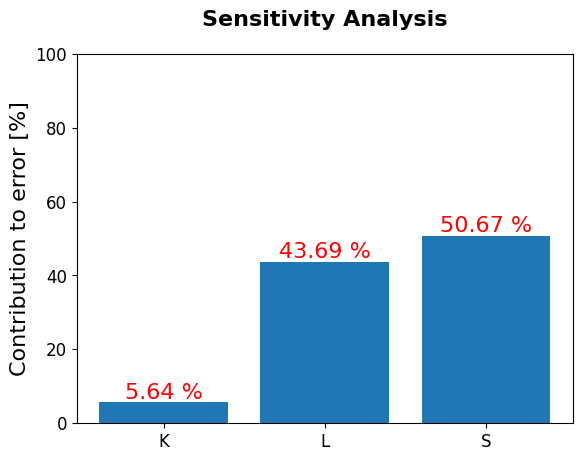

In [3]:
verbose = False
calculate()

# ^^^^BT^^^^

# BE BELOW


 B  = 4.433250e-05 +/- 6.630392e-06


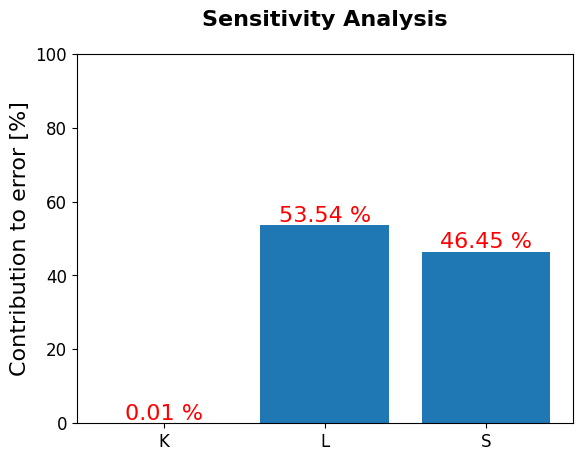

In [4]:
verbose = False
calculate()

# e/m calc


 em  = 1.281732e+11 +/- 1.036850e+10


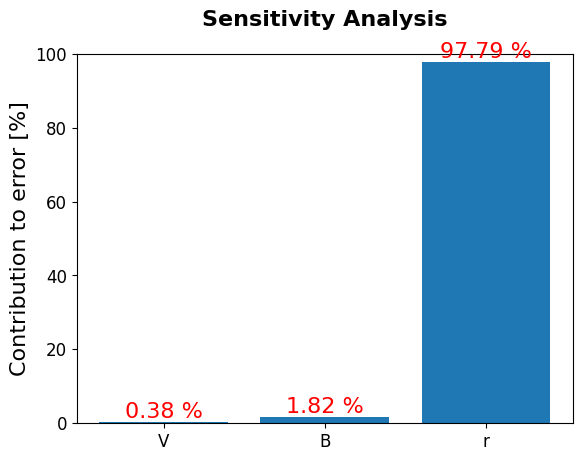

In [6]:
verbose = False
calculate()


 B  = 6.134405e+00 +/- 1.448836e-01


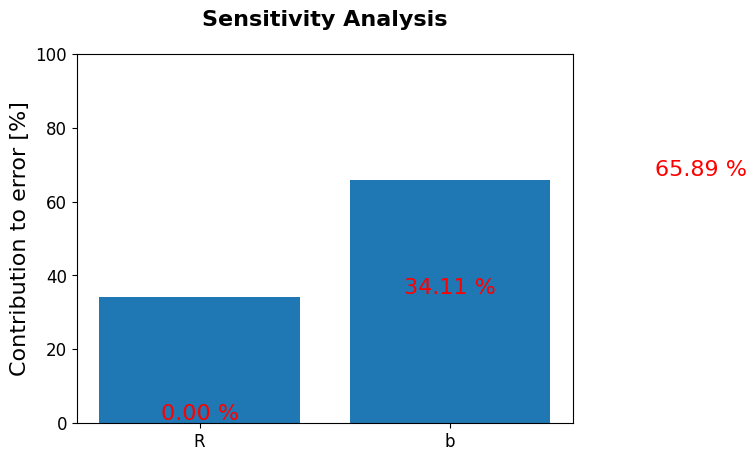

In [8]:
verbose = False
calculate()